In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, auc, precision_score, roc_auc_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# Experiments block
import wandb


pd.set_option('display.max_columns', None)

In [3]:
# Подготовим инфраструктуру для версионирования экспериментов
project_name = "Makarov_mfdp_unit_5"
exp_name = "exp_"
config = []

## Эксперимент 1 - работа с выбросами и аномалиями
Попытаемся оттолкнуться от данных - есть идея в первую очередь отфильтровать выбросы и аномальные данные в оригинальных таблицах. Для этого придётся загрузить оригинальные таблицы и отфильтровать выбросы в данных.

In [5]:
data_mortgage = pd.read_csv("data_mortgage_dr_enc.csv")
data_mortgage = data_mortgage.drop(["Unnamed: 0"], axis=1)
bureau = pd.read_csv("bureau.csv")
prev_appl = pd.read_csv("previous_application.csv")

In [9]:
bureau_appl = bureau[bureau["SK_ID_CURR"].isin(data_mortgage["SK_ID_CURR"])]
prev_appl_ = prev_appl[prev_appl["SK_ID_CURR"].isin(data_mortgage["SK_ID_CURR"])]

Обработка выбросов будет произведена в два подхода
1. Локализация и визуализация выбросов (будет закомменчена в ноутбуке для краткости)
2. Удаление выбросов (итоговая фильтрация)

### Тестирование автоудаления выбросов на колонке с очевидными выбросами - доход

In [10]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, max_samples='auto', random_state=42, contamination=float(0.05))

model.fit(data_mortgage[['AMT_INCOME_TOTAL']])

print(model.get_params())

{'bootstrap': False, 'contamination': 0.05, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}


<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

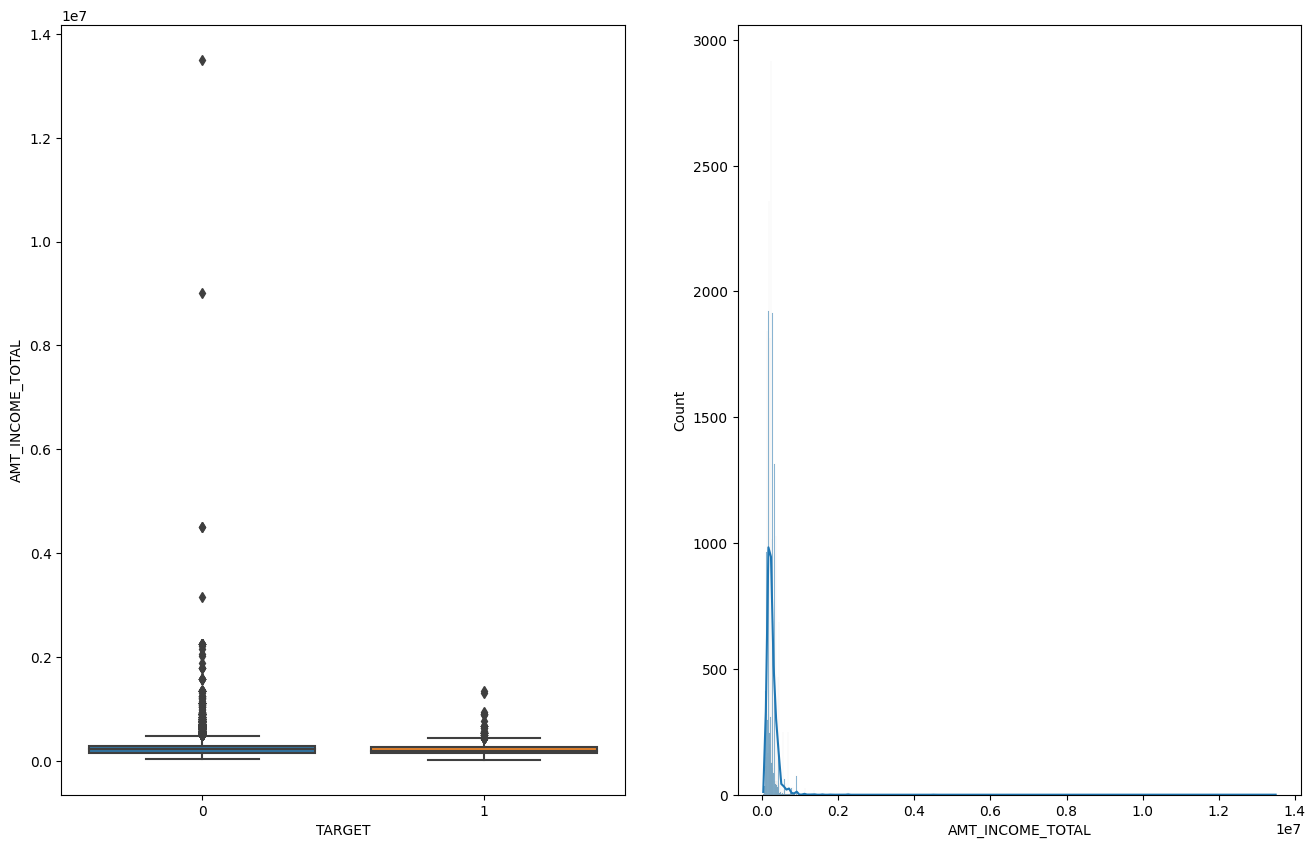

In [11]:
#fig = plt.figure()

fig, axs = plt.subplots(ncols=2)

fig.set_size_inches(16, 10)
    
sns.boxplot(y='AMT_INCOME_TOTAL', x=data_mortgage['TARGET'].astype('category'), data=data_mortgage, ax=axs[0])

    #plt.show()
    
sns.histplot(x=data_mortgage['AMT_INCOME_TOTAL'], kde=True, ax=axs[1])

In [12]:
data = pd.DataFrame()
data['scores'] = model.decision_function(data_mortgage[['AMT_INCOME_TOTAL']])

data['anomaly_score'] = model.predict(data_mortgage[['AMT_INCOME_TOTAL']])

data['AMT_INCOME_TOTAL'] = data_mortgage['AMT_INCOME_TOTAL']
data['TARGET'] = data_mortgage['TARGET']

data[data['anomaly_score']==-1]

,scores,anomaly_score,AMT_INCOME_TOTAL,TARGET
27,-0.079665,-1,765000.0,0
36,-0.050916,-1,607500.0,0
51,-0.006197,-1,540000.0,0
55,-0.059088,-1,54000.0,1
79,-0.067815,-1,720000.0,0
...,...,...,...,...
24765,-0.006197,-1,540000.0,0
24788,-0.183668,-1,1350000.0,0
24857,-0.003266,-1,517500.0,0
24868,-0.014939,-1,546250.5,0


<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

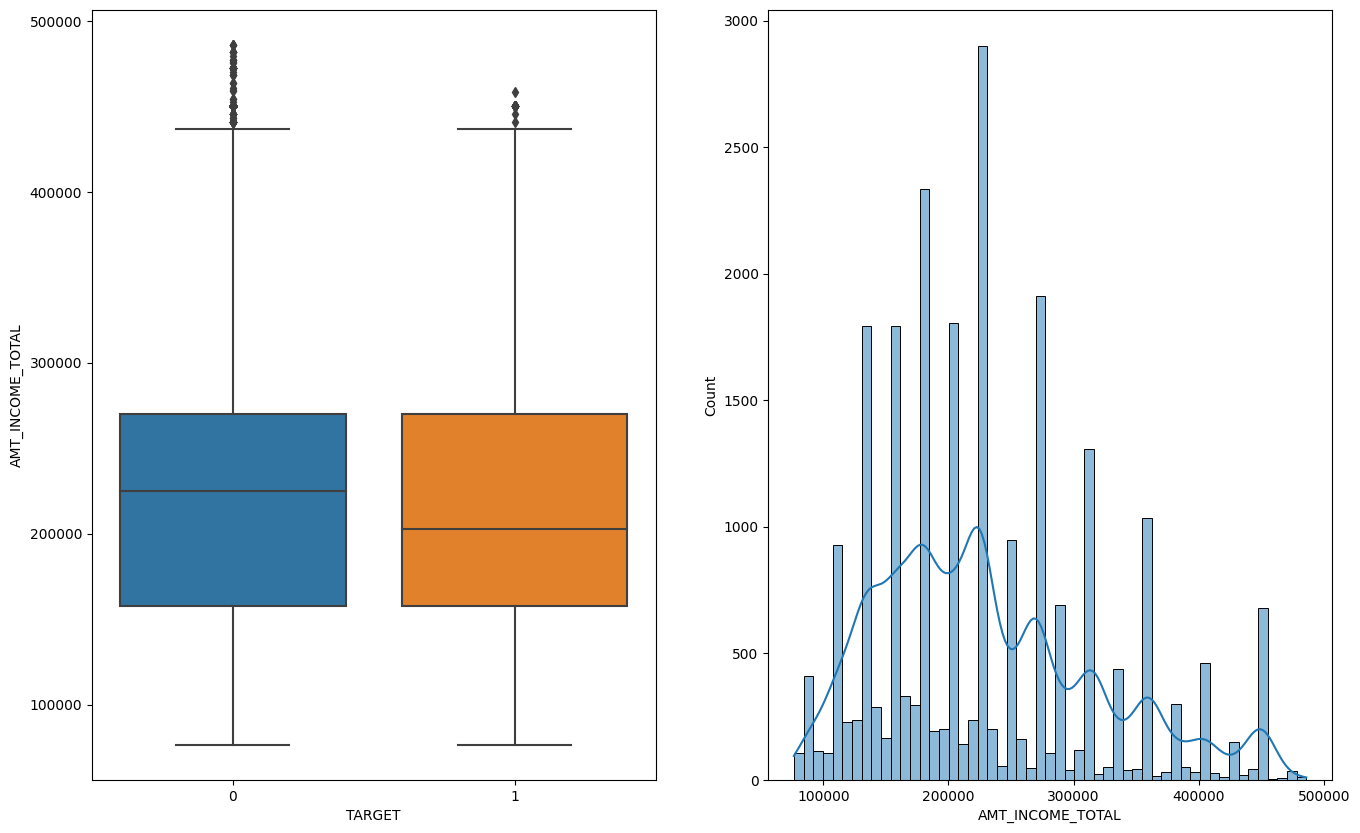

In [13]:
fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(16, 10)
sns.boxplot(y='AMT_INCOME_TOTAL', x=data['TARGET'].astype('category'), data=data[data['anomaly_score']>-1], ax=axs[0])
sns.histplot(x=data[data['anomaly_score']>-1]['AMT_INCOME_TOTAL'], kde=True, ax=axs[1])

### Удаление выбросов с предварительным импутером

In [14]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

imp_mean = IterativeImputer(random_state=0, initial_strategy="median")

dm_filled = pd.DataFrame(imp_mean.fit_transform(data_mortgage))

In [15]:
dm_filled.columns = data_mortgage.columns
dm_filled = dm_filled.astype(data_mortgage.dtypes.to_dict())
dm_filled

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_

In [39]:
dm_columns_with_outliers = [
    'AMT_INCOME_TOTAL', # есть очевидные выбросы по огромным зарплатам, но они значимы
    'DAYS_EMPLOYED', # одно аномальное значение (<10000)
    'DAYS_REGISTRATION', # > 25% (-17000)
    #'OWN_CAR_AGE', # quantization
    #'CNT_FAM_MEMBERS',
]

In [40]:
# сделаем цикл, который фильтрует выбросы в табличке
dm_ = dm_filled.copy()

for col in dm_columns_with_outliers:

    # фитим модель
    model.fit(dm_[[col]])
    
    # запредиктим аномалии
    dm_['anomaly_score'] = model.predict(dm_[[col]])

    # отбросим аномалии
    dm_ = dm_[dm_['anomaly_score']>-1]    

dm_

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_

In [41]:
# Итоговые колонки для фильтрации
b_columns_with_outliers = [
    'DAYS_CREDIT_ENDDATE',
    'DAYS_CREDIT_UPDATE',
]

In [42]:
# Итоговые колонки для фильтрации
p_columns_with_outliers = [
    'AMT_DOWN_PAYMENT',
    'AMT_GOODS_PRICE',
    'RATE_DOWN_PAYMENT',
    #'RATE_INTEREST_PRIMARY',
    'SELLERPLACE_AREA',
     #'DAYS_FIRST_DRAWING',
     #'DAYS_FIRST_DUE',
     #'DAYS_LAST_DUE_1ST_VERSION',
     #'DAYS_LAST_DUE',
     #'DAYS_TERMINATION',
]

In [43]:
b_ = bureau_appl.copy()

b_['DAYS_CREDIT_ENDDATE'] = b_['DAYS_CREDIT_ENDDATE'].fillna(0)

for col in b_columns_with_outliers:

    # фитим модель
    model.fit(b_[[col]])
    
    # запредиктим аномалии
    b_['anomaly_score'] = model.predict(b_[[col]])

    # отбросим аномалии
    b_ = b_[b_['anomaly_score']>-1]    

In [44]:
p_ = prev_appl_.copy()

for col in p_columns_with_outliers:
    p_[col] = p_[col].fillna(p_[col].min())
    # фитим модель
    model.fit(p_[[col]])
    
    # запредиктим аномалии
    p_['anomaly_score'] = model.predict(p_[[col]])

    # отбросим аномалии
    p_ = p_[p_['anomaly_score']>-1]   

### Далее  - предобработка признаков, как в EDA

In [45]:
# Функция агрегации числовых колонок. 

def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [46]:
# Функция для агрегации категориальных колонок
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [47]:
bureau_agg_new = agg_numeric(b_.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum,bureau_anomaly_score_count,bureau_anomaly_score_mean,bureau_anomaly_score_max,bureau_anomaly_score_min,bureau_anomaly_score_sum
0,100003,3,-1005.666667,-606,-1636,-3017,3,0.0,0,0,0,3,85.333333,1216.0,-540.0,256.0,2,-580.500000,-540.0,-621.0,-1161.0,3,0.0,0.0,0.0,0.0,3,0.0,0,0,0,3,331717.500000,810000.0,72652.5,995152.500,3,0.000000,0.0,0.0,0.000,3,270000.0,810000.0,0.0,810000.0,3,0.0,0.0,0.0,0.0,3,-377.666667,-43,-550,-1133,0,NaN,NaN,NaN,0.0,3,1.0,1,1,3
1,100009,17,-1176.764706,-239,-2018,-20005,17,0.0,0,0,0,17,-621.588235,1402.0,-1774.0,-10567.0,13,-1028.230769,-313.0,-1774.0,-13367.0,4,0.0,0.0,0.0,0.0,17,0.0,0,0,0,17,267841.852941,1777500.0,35770.5,4553311.500,14,76953.535714,557959.5,0.0,1077349.500,11,0.0,0.0,0.0,0.0,17,0.0,0.0,0.0,0.0,17,-775.117647,-23,-1549,-13177,0,NaN,NaN,NaN,0.0,17,1.0,1,1,17
2,100010,2,-1939.500000,-1138,-2741,-3879,2,0.0,0,0,0,2,-119.500000,689.0,-928.0,-239.0,1,-1138.000000,-1138.0,-1138.0,-1138.0,0,NaN,NaN,NaN,0.0,2,0.0,0,0,0,2,495000.000000,675000.0,315000.0,990000.000,2,174003.750000,348007.5,0.0,348007.500,1,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,-578.000000,-18,-1138,-1156,0,NaN,NaN,NaN,0.0,2,1.0,1,1,2
3,100055,7,-876.857143,-161,-2202,-6138,7,0.0,0,0,0,7,-66.000000,746.0,-806.0,-462.0,3,-655.333333,-370.0,-806.0,-1966.0,1,0.0,0.0,0.0,0.0,7,0.0,0,0,0,7,403818.859286,1370254.5,48150.0,2826732.015,5,248887.611000,1210297.5,0.0,1244438.055,4,0.0,0.0,0.0,0.0,7,0.0,0.0,0.0,0.0,7,-288.000000,-13,-789,-2016,0,NaN,NaN,NaN,0.0,7,1.0,1,1,7
4,100071,4,-1594.250000,-1106,-2258,-6377,4,0.0,0,0,0,4,-1158.500000,-740.0,-1977.0,-4634.0,4,-1165.250000,-850.0,-1977.0,-4661.0,0,NaN,NaN,NaN,0.0,4,0.0,0,0,0,4,149514.750000,184500.0,126000.0,598059.000,3,0.000000,0.0,0.0,0.000,3,0.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,4,-687.500000,-593,-970,-2750,0,NaN,NaN,NaN,0.0,4,1.0,1,1,4


In [48]:
bureau_counts = count_categorical(b_, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100003,1,0.333333,2,0.666667,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,1,0.333333,2,0.666667,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100009,4,0.235294,13,0.764706,0,0.0,17,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,15,0.882353,2,0.117647,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100010,1,0.500000,1,0.500000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,1,0.500000,0,0.000000,1,0.5,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100055,4,0.571429,3,0.428571,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,1,0.142857,0,0.0,5,0.714286,1,0.142857,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100071,0,0.000000,4,1.000000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,4,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [57]:
# Смержим статистики в основную таблицу

train = dm_.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

train = train.merge(bureau_agg_new, on = 'SK_ID_CURR', how = 'left')

In [58]:
# Повторим подход по данным банка

prev_appl_agg_new = agg_numeric(p_.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'prev')
prev_appl_counts = count_categorical(p_, group_var = 'SK_ID_CURR', df_name = 'prev')

train = train.merge(prev_appl_counts, on = 'SK_ID_CURR', how = 'left')

train = train.merge(prev_appl_agg_new, on = 'SK_ID_CURR', how = 'left')

In [59]:
# Функция для подсчёта пропусков:

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [60]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 691 columns.
There are 479 columns that have missing values.


,Missing Values,% of Total Values
prev_RATE_INTEREST_PRIVILEGED_mean,21632,98.8
prev_RATE_INTEREST_PRIMARY_mean,21632,98.8
prev_RATE_INTEREST_PRIMARY_max,21632,98.8
prev_RATE_INTEREST_PRIMARY_min,21632,98.8
prev_RATE_INTEREST_PRIVILEGED_max,21632,98.8
prev_RATE_INTEREST_PRIVILEGED_min,21632,98.8
bureau_AMT_ANNUITY_mean,16609,75.9
bureau_AMT_ANNUITY_max,16609,75.9
bureau_AMT_ANNUITY_min,16609,75.9
bureau_AMT_CREDIT_MAX_OVERDUE_min,9169,41.9


In [61]:
# Есть практически пустые колонки. Удалим их
missing_columns = list(missing_train.index[missing_train['% of Total Values'] > 90])

train = train.drop(columns = missing_columns)
len(missing_columns)

6

In [62]:
# Функции для фильтрации коррелирующих признаков

corrs = train.corr()

corrs = corrs.sort_values('TARGET', ascending = False)

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  192


In [63]:
train_corrs_removed = train.drop(columns = cols_to_remove)
train_corrs_removed.shape

(21897, 493)

In [72]:
train_corrs_removed.to_csv("1_outliers_raw_data.csv", index=False)

### Перезапустим эксперимент

In [65]:
X = train_corrs_removed.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
y = train_corrs_removed["TARGET"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.2)

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=100,  # Modify this parameter as needed
    thread_count=8, 
    custom_metric = ['F1:use_weights=true', 
                     'Precision:use_weights=true', 
                     'Recall:use_weights=true', 
                     'Accuracy:use_weights=true', 
                     'NormalizedGini:use_weights=true'],
    eval_metric='AUC',  # Changed to AUC
    auto_class_weights='Balanced' ,
    verbose=100,  # Output the training process every 100 iterations
    random_seed=42
    
)

# Create a pandas dataframe for easier visualization
def create_importance_df(X_train, feature_importances):
    importance_df = pd.DataFrame({
        'Features': X_train.columns,
        'Importance': feature_importances
    })
    
    # Sort the dataframe based on the feature importances
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    return importance_df

# Get feature importances
def get_feature_importances():
    feature_importances = catboost_model.get_feature_importance()
    importance_df = importance_df_dr

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Features'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()

Learning rate set to 0.175002
0:	test: 0.7227598	best: 0.7227598 (0)	total: 19.7ms	remaining: 1.95s
99:	test: 0.8623932	best: 0.8697530 (84)	total: 1.68s	remaining: 0us

bestTest = 0.8697530266
bestIteration = 84

Shrink model to first 85 iterations.


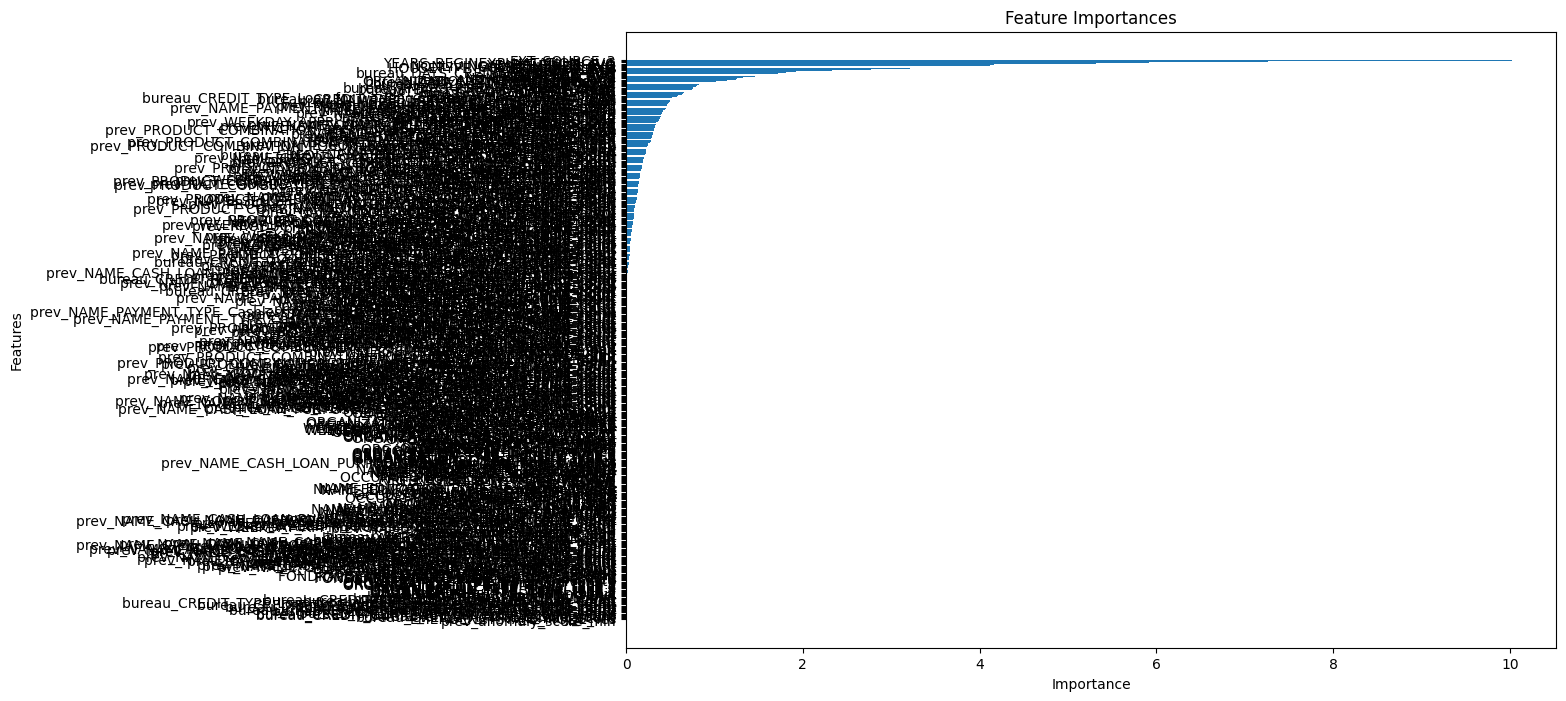

In [66]:
# Установочный запуск + иницииализация параметров
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)


# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Create a pandas dataframe for easier visualization
importance_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': feature_importances
})

# Sort the dataframe based on the feature importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Features'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Learning rate set to 0.175002
0:	test: 0.7686286	best: 0.7686286 (0)	total: 22.2ms	remaining: 2.2s
99:	test: 0.8633637	best: 0.8651235 (35)	total: 678ms	remaining: 0us

bestTest = 0.8651234867
bestIteration = 35

Shrink model to first 36 iterations.
Learning rate set to 0.175002
0:	test: 0.7318518	best: 0.7318518 (0)	total: 6.8ms	remaining: 673ms
99:	test: 0.8489404	best: 0.8552659 (51)	total: 664ms	remaining: 0us

bestTest = 0.8552658596
bestIteration = 51

Shrink model to first 52 iterations.
Learning rate set to 0.175002
0:	test: 0.7463206	best: 0.7463206 (0)	total: 7.75ms	remaining: 767ms
99:	test: 0.8485569	best: 0.8524455 (81)	total: 658ms	remaining: 0us

bestTest = 0.8524455206
bestIteration = 81

Shrink model to first 82 iterations.


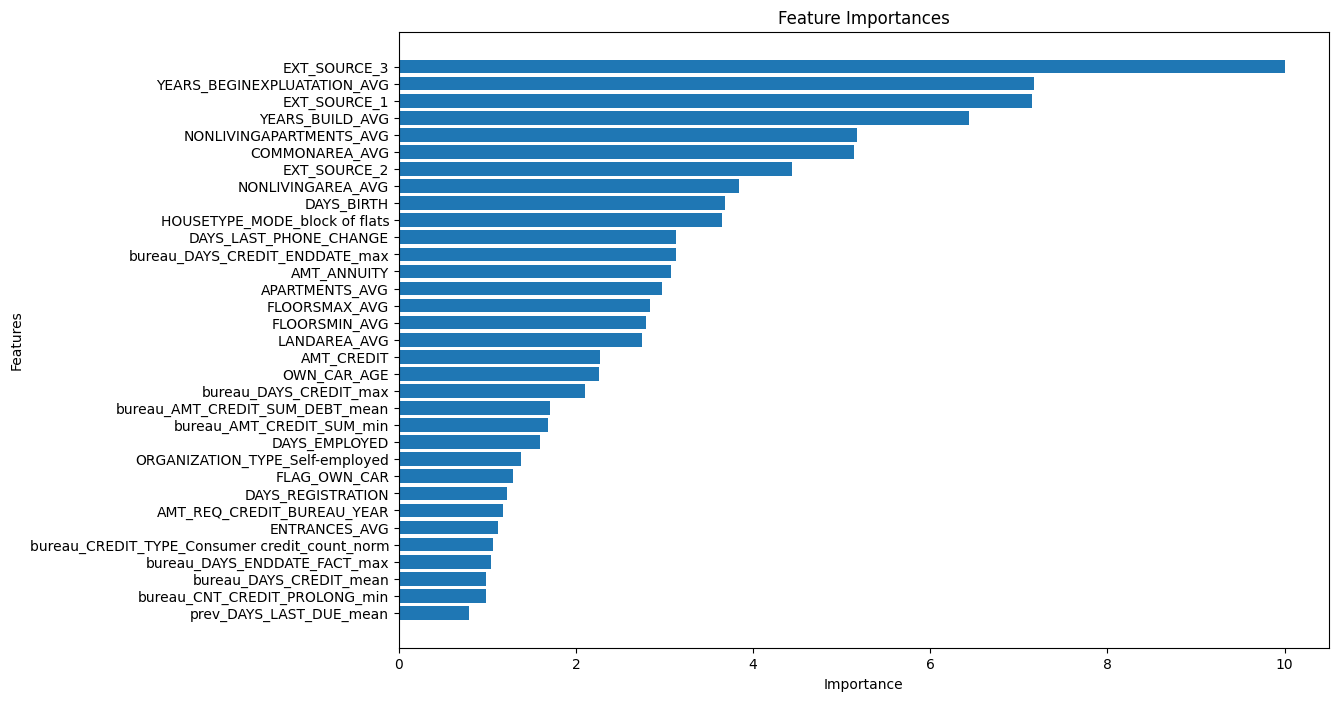

{'learn': {'Accuracy:use_weights=true': 0.9612241890915794,
  'Logloss': 0.20045720625942243,
  'Precision:use_weights=true': 0.9349444123416472,
  'F1:use_weights=true': 0.9623612738187792,
  'Recall:use_weights=true': 0.9914346895074947},
 'validation': {'NormalizedGini:use_weights=true': 0.7048910411622276,
  'Accuracy:use_weights=true': 0.7697316188901686,
  'Logloss': 0.5010999508203222,
  'Precision:use_weights=true': 0.8883811013816917,
  'F1:use_weights=true': 0.7683884504546241,
  'Recall:use_weights=true': 0.748,
  'AUC': 0.8524455205811138}}

In [67]:
importance_df_dr = importance_df
features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
train_dropped = train_corrs_removed.drop(columns=features_to_drop)



while len(importance_df_dr[importance_df_dr["Importance"] <= 0.5]) > 0:
   
    X_dr = train_dropped.drop(columns=["TARGET"]).set_index("SK_ID_CURR")
    y_dr = train_dropped["TARGET"]
    
    X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(X_dr, y_dr, 
                                                        random_state=42, 
                                                        test_size=0.2)
    
    # Fit model
    catboost_model.fit(X_train_dr, y_train_dr, eval_set=(X_test_dr, y_test_dr), use_best_model=True)
    feature_importances_dr = catboost_model.get_feature_importance()
    importance_df_dr = create_importance_df(X_train_dr, feature_importances_dr)
    features_to_drop = importance_df_dr[importance_df_dr["Importance"] <= 0.5]["Features"]
    train_dropped = train_dropped.drop(columns=features_to_drop)
get_feature_importances()
catboost_model.get_best_score()

In [68]:
print(classification_report(y_test, catboost_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      4130
           1       0.28      0.60      0.38       250

    accuracy                           0.89      4380
   macro avg       0.63      0.75      0.66      4380
weighted avg       0.93      0.89      0.91      4380



In [69]:
y_pred = catboost_model.predict_proba(X_test)[:, 1]
config = {
    "contamination": 0.05,
}

wandb.init(
        project=project_name, name=exp_name+"1"+"_outliers_fixed", config=config
    )  # Инициализация эксперимента, project - название проекта
wandb.log(
    {
        "accuracy_score": accuracy_score(y_true=y_test, y_pred=catboost_model.predict(X_test)),
        "f1_score_weighted": f1_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "precision_weighted": precision_score(y_true=y_test, y_pred=catboost_model.predict(X_test), average="weighted"),
        "roc_auc_score": roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted"),
        "gini": 2 * roc_auc_score(y_true=y_test, y_score=y_pred, average="weighted") - 1
    }
)
wandb.sklearn.plot_roc(y_true = y_test, y_probas = catboost_model.predict_proba(X_test))
#wandb.sklearn.plot_class_proportions(y_train, y_test)
wandb.finish()

accuracy_score,▁
f1_score_weighted,▁
gini,▁
precision_weighted,▁
roc_auc_score,▁
accuracy_score,0.88744
f1_score_weighted,0.90617
gini,0.70489
precision_weighted,0.93412
roc_auc_score,0.85245


In [70]:
best_features = importance_df_dr["Features"]
best_features.to_csv("1_best_features_names_out.csv", index=False)
train_dropped.to_csv("1_best_features_out.csv", index=False)